## 1. Use adapted variant of the categorise function

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import unidecode
sns.set_context("talk")


def categorise(source, target):
    """
    Return a numerical label indicating inflection class.

    Args:
        source (str): source with gender as first character ("<f> k a t z e ")
        target (str): (predicted) target

    Returns:
        int indicating class, ranges from 0 - 6
    """
    assert "<" in source.split()[0], "Your source sequence has no gender tag!"

    source = source.replace(" </s>", "")
    target = target.replace(" </s>", "")
    source = unidecode.unidecode(source).split()[1:]
    target = unidecode.unidecode(target).split()

    # zero or epsilon
    if target == source:
        category = 2
    else:
        # (e)n
        if source[-1] != "n" and target[-1:] == ["n"]:
            category = 0
        # e
        elif source[-1] != "e" and target[-1:] == ["e"]:
            category = 1
        # e r
        elif source[-2:] != ["e", "r"] and target[-2:] == ["e", "r"]:
            category = 3
        # s
        elif source[-1] != "s" and target[-1:] == ["s"]:
            category = 4
        # repeated input but odd suffix
        else:
            category = 5
    return category


## 2. Visualise!

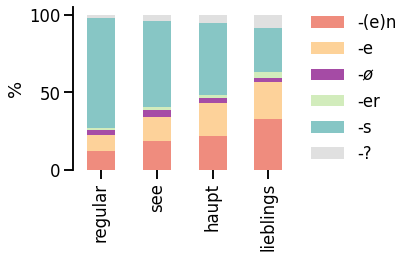

In [7]:
import pandas as pd
import unidecode
import numpy as np
import enchant
from matplotlib.colors import ListedColormap
d = enchant.Dict("en_US")

data = dict()
for setup, name in [("", "regular"), ("_see", "see"), #("_not", "not"),
                    ("_haupt", "haupt"),
                    ("_lieblings", "lieblings")]:

    lengths = []
    for epoch in [25]:
        counts = Counter()
        for seed in range(1, 6):
            with open(f"../wiktionary/s_length{setup}.src", encoding="utf-8") as f_src, \
                 open(f"../opennmt/models/seed={seed}_wiktionary/length/lstms2s_length{setup}_{epoch}.prd", encoding="utf-8") as f_prd:
                for src, tgt in zip(f_src, f_prd):
                    lengths.append(len(src.split()))
                    cat = categorise(src, tgt)
                    if cat == 6:
                        cat = 5
                    counts[cat] += 1
        data[name] = {x: counts[x] / (17 * 6 * 5) * 100 for x in range(6)}

a = pd.DataFrame(data)
colours = sns.color_palette("Spectral", 5) + ["lightgrey"]
colours[2] = "purple"

ax = a.T.plot(kind="bar", stacked=True, colormap=ListedColormap(colours), alpha=0.7,
              figsize=(4, 3))
ax.set_xticklabels(a.keys())
plt.ylabel("%")
sns.despine(bottom=True, right=True, top=True)
plt.legend(frameon=False, bbox_to_anchor=(1, 1.05), labels=["-(e)n", "-e", r"-$\o$", "-er", "-s", "-?"])
plt.savefig(f"figures/s_length.pdf", bbox_inches="tight")